In [144]:
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

#from sklearn import set_config; set_config(display='diagram')

# Data

## Read df

In [145]:
storedf = pd.read_csv("../raw_data/stores.csv")

In [146]:
storedf.shape

(54, 5)

In [147]:
oildf = pd.read_csv("../raw_data/oil.csv")

In [148]:
oildf.shape

(1218, 2)

In [149]:
holidaysdf = pd.read_csv("../raw_data/holidays_events.csv")
holidaysdf.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [150]:
holidaysdf_new = holidaysdf[holidaysdf["transferred"]==False]
holidaysdf_new["effective_type"] = "holiday"
holidaysdf_new = holidaysdf_new[["date","effective_type"]]
holidaysdf_new.head(1)

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_2968/2308325510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidaysdf_new["effective_type"] = "holiday"


,date,effective_type
0,2012-03-02,holiday


In [151]:
holidaysdf_new["effective_type"].value_counts()

holiday    338
Name: effective_type, dtype: int64

In [152]:
holidaysdf_new.head(1)

,date,effective_type
0,2012-03-02,holiday


In [153]:
holidaysdf.tail(1)

,date,type,locale,locale_name,description,transferred
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [154]:
transactiondf = pd.read_csv("../raw_data/transactions.csv")
transactiondf.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [155]:
train = pd.read_csv("../raw_data/train.csv")
train.tail(1)

,id,date,store_nbr,family,sales,onpromotion
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [156]:
train.head(1)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [157]:
test = pd.read_csv("../raw_data/test.csv")
test.head(1)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


In [158]:
submission_sample = pd.read_csv("../raw_data/sample_submission.csv")
submission_sample.head(1)

,id,sales
0,3000888,0.0


In [159]:
train.shape

(3000888, 6)

## train

### Build train df

In [160]:
train_temp = train.merge(holidaysdf_new, on ="date", how="left")
train_temp.effective_type.value_counts()

holiday    486486
Name: effective_type, dtype: int64

In [161]:
train_temp["effective_type"].value_counts()

holiday    486486
Name: effective_type, dtype: int64

In [162]:
train_temp2 = train_temp.merge(storedf, on="store_nbr", how="left")
train_temp2.head(1)

,id,date,store_nbr,family,sales,onpromotion,effective_type,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,holiday,Quito,Pichincha,D,13


In [163]:
train_temp3 = train_temp2.merge(transactiondf, how="left", left_on=["date","store_nbr"],right_on=["date", "store_nbr"])
train_temp3.head(1)

,id,date,store_nbr,family,sales,onpromotion,effective_type,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,holiday,Quito,Pichincha,D,13,NaN


In [164]:
train_new = train_temp3.merge(oildf, how= "left", on= "date")

### Type train

In [165]:
train_new["date"] = pd.to_datetime(train_new["date"])

In [166]:
train_new.dtypes

id                         int64
date              datetime64[ns]
store_nbr                  int64
family                    object
sales                    float64
onpromotion                int64
effective_type            object
city                      object
state                     object
type                      object
cluster                    int64
transactions             float64
dcoilwtico               float64
dtype: object

## test

### Build test df

In [167]:
test_temp = test.merge(holidaysdf_new, on ="date", how="left")

In [168]:
test_temp2 = test_temp.merge(storedf, on="store_nbr", how="left")

In [169]:
test_temp3 = test_temp2.merge(transactiondf, how="left", left_on=["date","store_nbr"],right_on=["date", "store_nbr"])

In [170]:
test_new = test_temp3.merge(oildf, how= "left", on= "date")
test_new.head(1)

,id,date,store_nbr,family,onpromotion,effective_type,city,state,type,cluster,transactions,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,Quito,Pichincha,D,13,NaN,46.8


### type test

In [171]:
test_new["date"] = pd.to_datetime(test_new["date"])

In [172]:
test_new.dtypes

id                         int64
date              datetime64[ns]
store_nbr                  int64
family                    object
onpromotion                int64
effective_type            object
city                      object
state                     object
type                      object
cluster                    int64
transactions             float64
dcoilwtico               float64
dtype: object

# Preprocessing

## Duplicates

In [173]:
train_new.duplicated().sum()

53460

In [174]:
train_new = train_new.drop_duplicates()

## Null values

In [175]:
train_new.isnull().sum()

id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
effective_type    2567862
city                    0
state                   0
type                    0
cluster                 0
transactions       245784
dcoilwtico         928422
dtype: int64

In [176]:
train_new.effective_type.replace(np.nan, "NotHoliday", inplace=True)

In [177]:
train_new.transactions.replace(np.nan, "0", inplace=True)

In [178]:
train_new.shape

(3000888, 13)

    CONSIDER DROP OIL PRICE BECAUSE 30% IMPUTED AND COORELATION

In [179]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean") # Instanciate a SimpleImputer object with strategy of choice
imputer.fit(train_new[['dcoilwtico']]) # Call the "fit" method on the object
train_new['dcoilwtico'] = imputer.transform(train_new[['dcoilwtico']])

## outliers

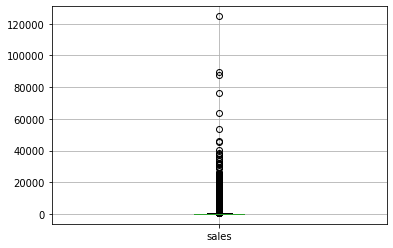

In [180]:
train_new[['sales']].boxplot();

## Scaling

In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Instanciate StandarScaler
scaler.fit(train_new[['sales']]) # Fit scaler to data
train_new['sales'] = scaler.transform(train_new[['sales']])

## Encoding

CONSIDER ENCODING CLUSTER AND STORE_NBR BECAUSE ORDINAL

In [182]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()

In [183]:
train_new['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [216]:
family_encoded = ohe.fit_transform(train_new[['family']])

In [217]:
#families = list(train_new['family'].unique())
#transposing_lst1 =[]
#for family in families:
#    family_columns = f"train_new['{family}']"
#    transposing_lst1.append(family_columns.strip('""'))

In [220]:
train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['PERSONAL CARE'],train_new['PET SUPPLIES'], train_new['PLAYERS AND ELECTRONICS'], train_new['POULTRY'],train_new['PREPARED FOODS'], train_new['PRODUCE'], train_new['SCHOOL AND OFFICE SUPPLIES'],train_new['SEAFOOD'] = family_encoded.T

In [68]:
train_new['effective_type'].unique()

array(['holiday', 'NotHoliday'], dtype=object)

In [74]:
ohe.fit(train_new[['effective_type']])
holiday_encoded = ohe.transform(train_new[['effective_type']])
train_new["holiday"], train_new["NotHoliday"] = holiday_encoded.transpose()

In [43]:
train_new['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [208]:
city_encoded = ohe.fit_transform(train_new[['city']])
train_new['Quito'], train_new['Cayambe'], train_new['Latacunga'], train_new['Riobamba'], train_new['Ibarra'], train_new['Santo Domingo'], train_new['Guaranda'], train_new['Puyo'], train_new['Ambato'], train_new['Guayaquil'], train_new['Salinas'], train_new['Daule'], train_new['Babahoyo'], train_new['Quevedo'], train_new['Playas'], train_new['Libertad'],train_new['Cuenca'], train_new['Loja'], train_new['Machala'], train_new['Esmeraldas'], train_new['Manta'], train_new['El Carmen'] = city_encoded.T

In [44]:
train_new['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [209]:
state_encoded = ohe.fit_transform(train_new[['state']])
train_new["Pichincha"], train_new["Cotopaxi"], train_new["Chimborazo"], train_new["Imbabura"], train_new["Santo Domingo de los Tsachilas"], train_new["Bolivar"], train_new["Pastaza"], train_new["Tungurahua"], train_new["Guayas"], train_new["Santa Elena"], train_new["Los Rios"], train_new["Azuay"], train_new["Loja"], train_new["El Oro"], train_new["Esmeraldas"], train_new["Manabi"] = state_encoded.T

In [45]:
train_new['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [210]:
type_encoded = ohe.fit_transform(train_new[['type']])
train_new["D"], train_new["C"], train_new["B"], train_new["E"], train_new["A"] = type_encoded.T

In [223]:
train_new.drop(columns=["family", "city", "state", "type", "effective_type"], inplace=True)

KeyError: "['family' 'city' 'state' 'type' 'effective_type'] not found in axis"

In [225]:
train_new.shape

(3000888, 82)

In [226]:
train_new.head(1)

,id,date,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,Quito,Cayambe,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,0,2013-01-01,1,-0.324661,0,13,0,67.925589,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
train_new["transactions"].dtypes

dtype('O')

# Model Time Series

In [237]:
from sklearn.
from sklearn.model_selection import cross_val_score

ImportError: cannot import name 'sarimax' from 'sklearn.model_selection' (/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/__init__.py)

In [228]:
X = train_new.drop(columns=["sales"])
y = train_new[["sales"]]

In [238]:
#train test split
train_size = 0.6
index = round(train_size*train_new.shape[0])

df_train = train_new.iloc[:index]
df_test = train_new.iloc[index:]

In [239]:
y_pred = df_test.shift(1)
y_pred

,id,date,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,Quito,Cayambe,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
1825481,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1825482,1800533.0,2015-10-10,29.0,-0.324661,0.0,10.0,944.0,67.925589,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1825483,1800534.0,2015-10-10,29.0,-0.321939,0.0,10.0,944.0,67.925589,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1825484,1800535.0,2015-10-10,29.0,-0.074207,0.0,10.0,944.0,67.925589,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1825485,1800536.0,2015-10-10,29.0,-0.321939,0.0,10.0,944.0,67.925589,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000882.0,2017-08-15,9.0,-0.319216,0.0,6.0,2155.0,47.570000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3054344,3000883.0,2017-08-15,9.0,0.072920,0.0,6.0,2155.0,47.570000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3054345,3000884.0,2017-08-15,9.0,-0.184413,1.0,6.0,2155.0,47.570000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3054346,3000885.0,2017-08-15,9.0,1.871105,148.0,6.0,2155.0,47.570000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [230]:
#model instantiation, training, scoring, predicting
model = 
model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:date, transactions

In [ ]:
model.score(X_test,y_test)
model.predict([[X]])